In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential,Model,model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten,Input,Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.optimizers import Adam
import glob
from PIL import Image
from PIL import ImageOps
from keras import backend as K
from keras.callbacks import TensorBoard
import h5py
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from scipy.spatial.distance import cosine

hai
Train on 1218 samples, validate on 1218 samples
Epoch 1/30
1218/1218 [==============================] - 11s - loss: 4.5991 - val_loss: 3.4871
Epoch 2/30
1218/1218 [==============================] - 11s - loss: 3.3823 - val_loss: 3.2256
Epoch 3/30
1218/1218 [==============================] - 11s - loss: 2.3236 - val_loss: 0.9134
Epoch 4/30
1218/1218 [==============================] - 11s - loss: 0.8405 - val_loss: 0.7644
Epoch 5/30
1218/1218 [==============================] - 11s - loss: 0.7582 - val_loss: 0.7509
Epoch 6/30
1218/1218 [==============================] - 11s - loss: 0.7471 - val_loss: 0.7415
Epoch 7/30
1218/1218 [==============================] - 11s - loss: 0.7379 - val_loss: 0.7309
Epoch 8/30
1218/1218 [==============================] - 11s - loss: 0.7312 - val_loss: 0.7231
Epoch 9/30
1218/1218 [==============================] - 11s - loss: 0.7243 - val_loss: 0.7264
Epoch 10/30
1218/1218 [==============================] - 11s - loss: 0.7201 - val_loss: 0.7165
Epoch 1

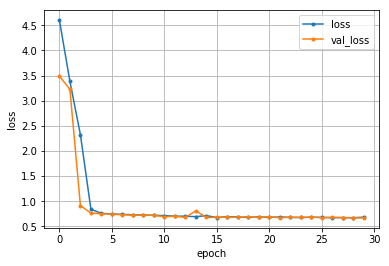

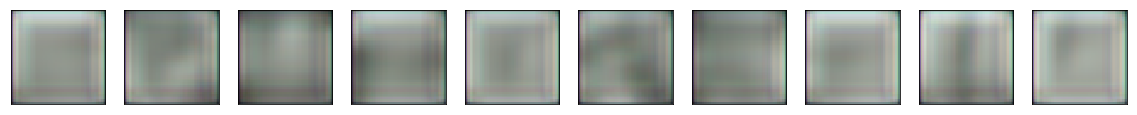

In [15]:
from keras.layers import Dense, Dropout, Activation, Flatten,Input
color = 3;
def dog_data_load():
    print("hai")
    list = glob.glob('dog/*')
    linumber = 1;
    
    image_li = np.empty((0,56,56,color), dtype=np.uint8)
    
    for i in list:
        #print(linumber)
        im = Image.open(i).resize((56,56))
        #print(im.shape)
        #im = im.convert("L")
        #print(im.shape)
        im_reading = np.array(im)
        
        #im_list = np.asarray(im_reading)
 
        #print("変換前")
        #print( im_reading.shape)
       
        #print("変換後")
        #print(im_reading.shape)
        
        image_li = np.append(image_li, [im_reading], axis=0)
        #print(image_li.shape)
        #print("korekore")
        #出力形式は(枚数, 1, 50, 50)
        #print(image_li.shape)
        linumber+=1
    return (image_li,image_li),(image_li,image_li)

hidden_layer1 = 256
hidden_layer2 = 64
hidden_layer3 = 3 # because you have 10 categories  
#encoding_dim = 32
input_img = Input(shape=(56,56,color))
x = Conv2D(48, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(48, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(24, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(3, (3, 3), activation='relu', padding='same')(x)
x = Dense(hidden_layer1, activation='relu')(x)
x = Dense(hidden_layer2, activation='relu')(x)
encoded = Dense(hidden_layer3, activation='softmax',name="softdog")(x)

encoder = Model(input_img,encoded)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional
x = Dense(hidden_layer2, activation='relu')(encoded)
x = Dense(hidden_layer1, activation='relu')(x)
x = Conv2D(24, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(48, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(48, (3, 3), activation='relu',padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='relu', padding='same',name="softdog2")(x)


autoencoder = Model(input_img, decoded)
AE_model = autoencoder
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

(x_train, y_train),(x_test,y_test) = dog_data_load()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.


x_train = np.reshape(x_train,(len(x_train),56,56,color))
x_test = np.reshape(x_test,(len(x_test),56,56,color))

history = autoencoder.fit(x_train, x_train,
                epochs=30,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='./tmp/autoencoder')]
               )

#精度をグラフに表示
loss = history.history['loss']
val_loss = history.history['val_loss']
nb_epoch = len(loss)
plt.plot(range(nb_epoch), loss, marker='.', label='loss')
plt.plot(range(nb_epoch), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')

decoded_imgs = autoencoder.predict(x_test,batch_size=256)
dog_features = decoded_imgs
print(decoded_imgs[1].shape)
# 何個表示するか
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # 変換された画像を表示
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(56, 56,color))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


autoencoder.save_weights('AE_Softmax.h5')

In [16]:
Test_image = 'test/main_53914_ccd62_detail.jpg'
Test_img = image.load_img(Test_image,target_size=(56,56))
Tx = img_to_array(Test_img)
Tx_= np.expand_dims(Tx,axis=0)
print(Tx.shape)
AE_Model =AE_model.load_weights('AE_Softmax.h5')
model = Model(input=AE_model.input,output=AE_model.get_layer('softdog').output)
print(AE_model.input)
print(AE_model.get_layer('softdog').output)
features = model.predict(Tx)
features = features.flatte().tolist()

socre = 1 - cosine(features,dog_features)
print(score)

(56, 56, 3)
Tensor("input_4:0", shape=(?, 56, 56, 3), dtype=float32)
Tensor("softdog_3/truediv:0", shape=(?, 7, 7, 3), dtype=float32)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("so...)`
  import sys


ValueError: Error when checking : expected input_4 to have 4 dimensions, but got array with shape (56, 56, 3)